In [1]:
import sys
#sys.path.append("/mnt/AI/wgs-database/phenotype_extractors/PhenoBERT/phenobert/utils")
from api import *

/mnt/home/jiansiaoyu/miniconda3/envs/pheno_bert37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 方案1: 批次處理 + 進度條
import pandas as pd
#from tqdm.notebook import tqdm
from tqdm import tqdm
from io import StringIO
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import time


# 啟用 tqdm 對 pandas 的支持
#tqdm.pandas()

def phenobert_predict_optimized(description):
    """優化後的單筆預測函數"""
    try:
        data_string = annotate_text(description)
        if not data_string.strip():  # 如果沒有結果
            return ""
        
        df = pd.read_csv(StringIO(data_string), sep='\t', header=None, 
                        names=['start', 'end', 'description', 'hpo_id', 'score', 'note'])
        df = df.sort_values(by='description')
        return ','.join(list(df.hpo_id))
    except Exception as e:
        print(f"Error processing description: {e}")
        return ""

def batch_phenobert_predict(descriptions, batch_size=10, max_workers=10):
    """
    批次處理版本 - 降低模型重新載入的開銷
    """
    results = []
    
    # 分批處理
    for i in tqdm(range(0, len(descriptions), batch_size), desc="Processing batches"):
        batch = descriptions[i:i+batch_size]
        batch_results = []
        
        # 對每個批次進行處理
        for desc in tqdm(batch, desc=f"Batch {i//batch_size + 1}", leave=False):
            result = phenobert_predict_optimized(desc)
            batch_results.append(result)
        
        results.extend(batch_results)
        
        # 每個批次後短暫休息，避免過熱
        time.sleep(0.1)
    
    return results

def parallel_phenobert_predict(descriptions, max_workers=3):
    """
    並行處理版本 - 注意：只有在確認模型線程安全時才使用
    """
    results = [None] * len(descriptions)
    
    def process_single(args):
        idx, desc = args
        try:
            result = phenobert_predict_optimized(desc)
            return idx, result
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            return idx, ""
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_single, (i, desc)) 
                  for i, desc in enumerate(descriptions)]
        
        for future in tqdm(futures, desc="Processing in parallel"):
            idx, result = future.result()
            results[idx] = result
    
    return results

In [3]:
df_hpo_mapping = pd.read_csv('../../reference/2025-08-01_orphanet_WGS_database(HPO_ID_Mapping_v20250506).csv', sep=',')

In [4]:
hpo_mapping_dict = {}
for idx in df_hpo_mapping.index:
    hpo_mapping_dict[df_hpo_mapping.input_hpo_id[idx]] = df_hpo_mapping.mapped_main_id[idx]

In [5]:
GSC_database = pd.read_excel('../../reference/GSC_database.xlsx',engine='openpyxl')

In [6]:
GSC_database.shape[0]

228

In [7]:
def hpo_map(hpo_id_list_str):
    if hpo_id_list_str =='-':
        return '-'
    hpo_id_list = hpo_id_list_str.split(',')
    normalized_hpo_id_list = []
    for hpo_id in hpo_id_list:
        if hpo_id not in normalized_hpo_id_list:
            normalized_hpo_id_list.append(hpo_mapping_dict.get(hpo_id,'-'))
    return ','.join(normalized_hpo_id_list)

def accuracy_calculator(true_hpo_str, pred_hpo_str):
    true_hpo_list = true_hpo_str.split(',')
    pred_hpo_list = pred_hpo_str.split(',')
    mapped_hpo_list = [hpo for hpo in pred_hpo_list if hpo in true_hpo_list]
    return len(mapped_hpo_list)/len(true_hpo_list)

In [8]:
GSC_database['normalized_hpo_ids'] = GSC_database['hpo_ids'].apply(hpo_map)

In [9]:
GSC_database['phenobert_hpo_ids'] = parallel_phenobert_predict(list(GSC_database['clinical_summary']))

Processing in parallel:   0%|▋                                                                                                                                               | 1/228 [00:02<10:58,  2.90s/it]

Error processing description: 'WordNetCorpusReader' object has no attribute 'subdir'


Processing in parallel:   0%|▋                                                                                                                                               | 1/228 [00:04<10:58,  2.90s/it]

loading vocabulary file /mnt/AI/wgs-database/phenotype_extractors/PhenoBERT/phenobert/embeddings/biobert_v1.1_pubmed/vocab.txt


Processing in parallel:   1%|█▎                                                                                                                                              | 2/228 [00:07<13:53,  3.69s/it]

Load pre-trained BERT parameters from file /mnt/AI/wgs-database/phenotype_extractors/PhenoBERT/phenobert/embeddings/biobert_v1.1_pubmed/pytorch_model.bin.


Processing in parallel: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [03:24<00:00,  1.12it/s]


In [10]:
GSC_database['phenobert_hpo_ids'] = GSC_database['phenobert_hpo_ids'].fillna('-')

In [11]:
GSC_database['normalized_phenobert_hpo_ids'] = GSC_database['phenobert_hpo_ids'].apply(hpo_map)

In [12]:
GSC_database['phenobert_accuracy'] = GSC_database.apply(lambda x:accuracy_calculator(x.normalized_hpo_ids, x.normalized_phenobert_hpo_ids), axis=1)

In [13]:
GSC_database['phenobert_accuracy'].mean()

0.5351608117047256

In [14]:
GSC_database.head()

,file_name,clinical_summary,hpo_terms,hpo_ids,normalized_hpo_ids,phenobert_hpo_ids,normalized_phenobert_hpo_ids,phenobert_accuracy
0,1003450,A syndrome of brachydactyly (absence of some m...,brachydactyly (HP:0001156);absence of some mid...,"HP:0001156,HP:0009881,HP:0001798,HP:0001792,HP...","HP:0001156,HP:0009881,HP:0001798,HP:0001792,HP...",,-,0.000000
1,10051003,Townes-Brocks syndrome (TBS) is an autosomal d...,autosomal dominant disorder (HP:0000006);varia...,"HP:0000006,HP:0003828,HP:0000356,HP:0000365,HP...","HP:0000006,HP:0003828,HP:0000356,HP:0000365,HP...","HP:0000356,HP:0000365,HP:0002023,HP:0001249,HP...","HP:0000356,HP:0000365,HP:0002023,HP:0001249,HP...",0.666667
2,10066029,Nevoid basal cell carcinoma syndrome (NBCCS) i...,basal cell carcinoma (HP:0002671);autosomal do...,"HP:0002671,HP:0000006,HP:0003828,HP:0002671,HP...","HP:0002671,HP:0000006,HP:0003828,HP:0010603,HP...","HP:0002671,HP:0005462,HP:0002514,HP:0002671,HP...","HP:0002671,HP:0005462,HP:0002514,HP:0010603,HP...",0.666667
3,10196695,Angelman syndrome (AS) is a neurodevelopmental...,neurodevelopmental disorder (HP:0000707);conti...,"HP:0000707,HP:0001466","HP:0000707,HP:0001466",HP:0012759,HP:0012759,0.000000
4,10417280,Prader-Willi syndrome (PWS) and Angelman syndr...,neurobehavioral disorders (HP:0000708);de novo...,"HP:0000708,HP:0003745","HP:0000708,HP:0003745",HP:0000708,HP:0000708,0.500000


In [18]:
GSC_database_phenotagger = pd.read_excel('../../reference/GSC_database_phenotagger.xlsx',engine='openpyxl')

In [25]:
GSC_database_phenotagger['file_name'] = GSC_database_phenotagger['PMID']
GSC_database_phenotagger['pheno_tagger_hpo_ids'] = GSC_database_phenotagger['hpo_ids']
GSC_database_merged = GSC_database.merge(GSC_database_phenotagger[['file_name','pheno_tagger_hpo_ids']], on=['file_name'], how='left')

In [26]:
GSC_database_merged['pheno_tagger_hpo_ids'] = GSC_database_merged['pheno_tagger_hpo_ids'].fillna('-')
GSC_database_merged['normalized_pheno_tagger_hpo_ids'] = GSC_database_merged['pheno_tagger_hpo_ids'].apply(hpo_map)

In [27]:
GSC_database_merged['pheno_tagger_accuracy'] = GSC_database_merged.apply(lambda x:accuracy_calculator(x.normalized_hpo_ids, x.normalized_pheno_tagger_hpo_ids), axis=1)

In [28]:
GSC_database_merged['pheno_tagger_accuracy'].mean()

0.5217332118554553

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 設定中文字型（如果需要顯示中文）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

def plot_phenobert_accuracy_distribution(df_phenopacket, column_name='phenobert_accuracy'):
    """
    繪製 PhenoBERT Accuracy 分數分布圖
    
    Parameters:
    df_phenopacket: DataFrame containing phenobert_accuracy column
    """
    
    # 建立分組區間 (0.0-0.1, 0.1-0.2, ..., 0.9-1.0)
    bins = np.arange(0, 1.1, 0.1)  # [0, 0.1, 0.2, ..., 1.0]
    
    # 創建圖表
    plt.figure(figsize=(10, 6))
    
    # 直方圖
    n, bins_edges, patches = plt.hist(df_phenopacket[column_name], 
                                     bins=bins, 
                                     edgecolor='black', 
                                     alpha=0.7,
                                     color='skyblue')
    
    plt.xlabel(f'{column_name} Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{column_name} Distribution', fontsize=14, fontweight='bold')
    plt.xticks(bins, [f'{i:.1f}' for i in bins])
    plt.grid(True, alpha=0.3)
    
    # 在每個bar上顯示數量
    for i, count in enumerate(n):
        if count > 0:
            plt.text(bins_edges[i] + 0.05, count + max(n)*0.01, 
                    f'{int(count)}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 顯示統計資訊
    print("=== PhenoBERT Recall 統計資訊 ===")
    print(f"總樣本數: {len(df_phenopacket[column_name])}")
    print(f"平均值: {df_phenopacket[column_name].mean():.4f}")
    print(f"中位數: {df_phenopacket[column_name].median():.4f}")
    print(f"標準差: {df_phenopacket[column_name].std():.4f}")
    print(f"最小值: {df_phenopacket[column_name].min():.4f}")
    print(f"最大值: {df_phenopacket[column_name].max():.4f}")
    
    # 顯示各區間的詳細統計
    print("\n=== 各分數區間統計 ===")
    bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
    counts, _ = np.histogram(df_phenopacket[column_name], bins=bins)
    percentages = (counts / len(df_phenopacket[column_name])) * 100
    
    for label, count, pct in zip(bin_labels, counts, percentages):
        print(f"{label}: {count:4d} 樣本 ({pct:5.1f}%)")

def plot_simple_histogram(df_phenopacket):
    """
    簡單版本的分布圖
    """
    bins = np.arange(0, 1.1, 0.1)
    
    plt.figure(figsize=(10, 6))
    plt.hist(df_phenopacket[column_name], 
             bins=bins, 
             edgecolor='black', 
             alpha=0.7,
             color='steelblue')
    
    plt.xlabel(f'{column_name} Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{column_name} Score Distribution', fontsize=14, fontweight='bold')
    plt.xticks(bins, [f'{i:.1f}' for i in bins])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 使用範例
# plot_phenobert_accuracy_distribution(df_phenopacket)

print("執行 plot_phenobert_accuracy_distribution(df_phenopacket) 來繪製分布圖")

執行 plot_phenobert_accuracy_distribution(df_phenopacket) 來繪製分布圖


In [33]:
phenopacket = pd.read_excel('../../reference/20250811_phenopacket_with_demographics_summary_phenobert_phenotagger_result.xlsx',engine='openpyxl')

In [39]:
phenopacket['phenobert_recall'] = phenopacket['phenobert_accuracy']
phenopacket['pheno_tagger_recall'] = phenopacket['pheno_tagger_accuracy']

In [32]:
GSC_database.head()

,file_name,clinical_summary,hpo_terms,hpo_ids,normalized_hpo_ids,phenobert_hpo_ids,normalized_phenobert_hpo_ids,phenobert_accuracy
0,1003450,A syndrome of brachydactyly (absence of some m...,brachydactyly (HP:0001156);absence of some mid...,"HP:0001156,HP:0009881,HP:0001798,HP:0001792,HP...","HP:0001156,HP:0009881,HP:0001798,HP:0001792,HP...","HP:0006167,HP:0001798,HP:0001363,HP:0001385,HP...","HP:0006167,HP:0001798,HP:0001363,HP:0001385,HP...",0.6
1,10051003,Townes-Brocks syndrome (TBS) is an autosomal d...,autosomal dominant disorder (HP:0000006);varia...,"HP:0000006,HP:0003828,HP:0000356,HP:0000365,HP...","HP:0000006,HP:0003828,HP:0000356,HP:0000365,HP...",,-,0.0
2,10066029,Nevoid basal cell carcinoma syndrome (NBCCS) i...,basal cell carcinoma (HP:0002671);autosomal do...,"HP:0002671,HP:0000006,HP:0003828,HP:0002671,HP...","HP:0002671,HP:0000006,HP:0003828,HP:0010603,HP...",,-,0.0
3,10196695,Angelman syndrome (AS) is a neurodevelopmental...,neurodevelopmental disorder (HP:0000707);conti...,"HP:0000707,HP:0001466","HP:0000707,HP:0001466",HP:0012759,HP:0012759,0.0
4,10417280,Prader-Willi syndrome (PWS) and Angelman syndr...,neurobehavioral disorders (HP:0000708);de novo...,"HP:0000708,HP:0003745","HP:0000708,HP:0003745",HP:0000708,HP:0000708,0.5


In [41]:
GSC_database.hpo_terms[0]

'brachydactyly (HP:0001156);absence of some middle or distal phalanges (HP:0009881);aplastic or hypoplastic nails (HP:0001798);hypoplastic nails (HP:0001792);symphalangism (HP:0100264);ankylois of proximal interphalangeal joints (HP:0008090);synostosis of some carpal and tarsal bones (HP:0009702);craniosynostosis (HP:0001363);dysplastic hip joints (HP:0001385);autosomal dominant trait (HP:0000006)'

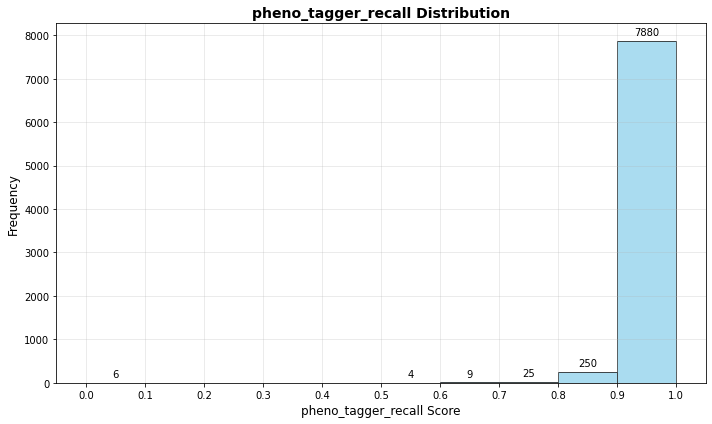

=== PhenoBERT Recall 統計資訊 ===
總樣本數: 8174
平均值: 0.9833
中位數: 1.0000
標準差: 0.0453
最小值: 0.0000
最大值: 1.0000

=== 各分數區間統計 ===
0.0-0.1:    6 樣本 (  0.1%)
0.1-0.2:    0 樣本 (  0.0%)
0.2-0.3:    0 樣本 (  0.0%)
0.3-0.4:    0 樣本 (  0.0%)
0.4-0.5:    0 樣本 (  0.0%)
0.5-0.6:    4 樣本 (  0.0%)
0.6-0.7:    9 樣本 (  0.1%)
0.7-0.8:   25 樣本 (  0.3%)
0.8-0.9:  250 樣本 (  3.1%)
0.9-1.0: 7880 樣本 ( 96.4%)


In [40]:
plot_phenobert_accuracy_distribution(phenopacket, 'pheno_tagger_recall')

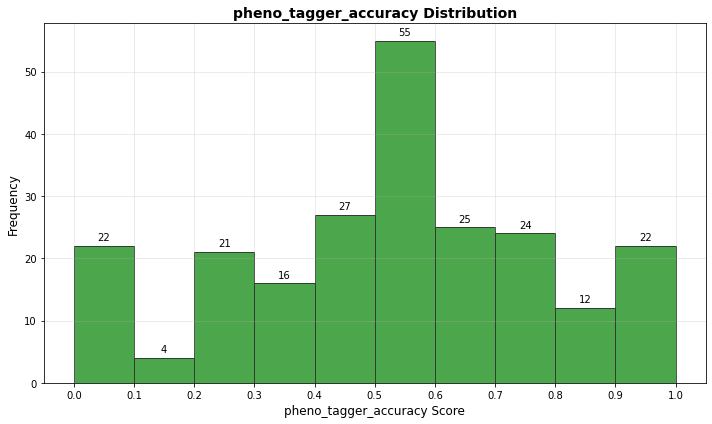

=== PhenoBERT Accuracy 統計資訊 ===
總樣本數: 228
平均值: 0.5217
中位數: 0.5000
標準差: 0.2689
最小值: 0.0000
最大值: 1.0000

=== 各分數區間統計 ===
0.0-0.1:   22 樣本 (  9.6%)
0.1-0.2:    4 樣本 (  1.8%)
0.2-0.3:   21 樣本 (  9.2%)
0.3-0.4:   16 樣本 (  7.0%)
0.4-0.5:   27 樣本 ( 11.8%)
0.5-0.6:   55 樣本 ( 24.1%)
0.6-0.7:   25 樣本 ( 11.0%)
0.7-0.8:   24 樣本 ( 10.5%)
0.8-0.9:   12 樣本 (  5.3%)
0.9-1.0:   22 樣本 (  9.6%)


In [30]:
plot_phenobert_accuracy_distribution(GSC_database_merged, column_name='pheno_tagger_accuracy')